In [243]:
% matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as st
import yaml
import phacsl.utils.formats.csv_tools as csv_tools
import os.path
from collections import defaultdict

from tools_util import readModelInputs, getFacDict

In [244]:
runDesc = '/home/welling/git/pyRHEA_github/src/sim/week_run_ChicagoLand.yaml'

inputDict = readModelInputs(runDesc)
facDict = getFacDict(inputDict)

totD = defaultdict(int)
nFacD = defaultdict(int)
for fac, rec in facDict.items():
    nFacD[rec['category']] += 1
    totD[rec['category']] += rec['meanPop']['value']
print 'totD: ', totD
print 'nFacD: ', nFacD


totD:  defaultdict(<type 'int'>, {'SNF': 44029.96048152038, 'HOSPITAL': 13839.558332146706, 'VSNF': 2359.043835616, 'COMMUNITY': 9082963, 'LTACH': 528.550274452})
nFacD:  defaultdict(<type 'int'>, {'SNF': 351, 'HOSPITAL': 90, 'VSNF': 12, 'COMMUNITY': 2260, 'LTACH': 9})


In [271]:
#fullDF = pd.read_msgpack('/home/welling/git/pyRHEA_github/src/tools/taumod_work6.mpk')
fullDF = pd.read_msgpack('/tmp/taumod_pass2.mpk')
print fullDF.columns

Index([u'colonized', u'current_best_tau', u'expected', u'fac', u'newTau',
       u'prev_max', u'prev_mean', u'prev_q1', u'prev_q2', u'prev_q3',
       u'prev_stdv', u'prevalence', u'ratio', u'samp', u'tau', u'tier',
       u'total'],
      dtype='object')


In [272]:
tierPairs = [('SNF', 'NURSING'), ('VSNF', 'NURSING'), ('HOSPITAL', 'HOSP'), ('HOSPITAL', 'ICU'),
            ('LTACH', 'LTAC'), ('VSNF', 'SKILNRS'), ('VSNF', 'VENT')]


In [273]:
#loc, tier = 'PRES_333_H', 'HOSP'
#loc, tier = 'PRES_333_H', 'ICU'
#loc, tier = 'ADVO_4440_H', 'HOSP'
#loc, tier = 'ADVO_4440_H', 'ICU'
#loc, tier = 'ADVO_3435_L', 'LTAC'
#loc, tier = 'PRES_400_S', 'NURSING'
#loc, tier = 'PARK_2320_V', 'NURSING'
#loc, tier = 'CHAT_7050_S', 'NURSING'
loc, tier = '*', 'NURSING'


In [274]:
%config InlineBackend.print_figure_kwargs = {'bbox_inches':None}
plt.rcParams["figure.figsize"] = [12, 4.5]

def plotLoc(loc, tier, fullDF):
    locDF = fullDF[np.logical_and(fullDF['fac']==loc, fullDF['tier']==tier)]
    fig, axes = plt.subplots(1, 2)
    axes[0].plot(locDF['samp'], locDF['newTau'], label='newTau')
    axes[0].plot(locDF['samp'], locDF['current_best_tau'], label='current_best')
    axes[0].plot(locDF['samp'], locDF['tau'], label='tau')
    axes[0].legend()
    axes[0].set_title('%s %s tau' % (loc, tier))
    axes[0].set_yscale('log')
    axes[1].plot(locDF['samp'], locDF['expected'], label='expected')
    axes[1].plot(locDF['samp'], locDF['prev_q1'], label='q1')
    axes[1].plot(locDF['samp'], locDF['prev_q2'], label='median')
    axes[1].plot(locDF['samp'], locDF['prev_q3'], label='q3')
    axes[1].plot(locDF['samp'], locDF['prevalence'], label='prevalence')
    axes[1].legend()
    axes[1].set_title('prevalence')
    #axes[1].set_yscale('log')
    plt.show()

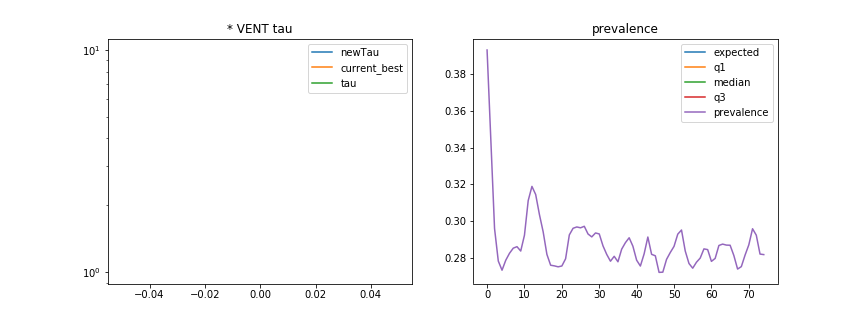

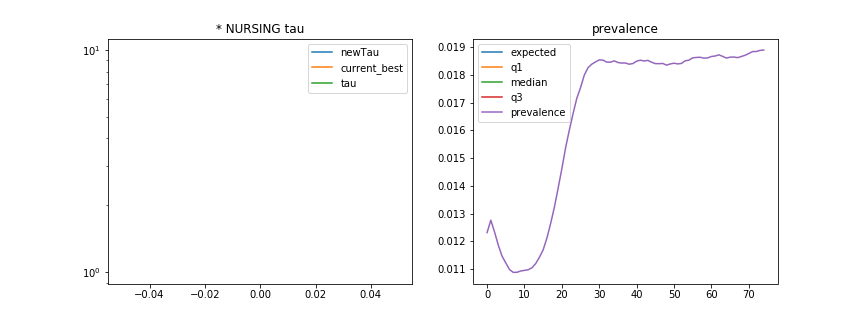

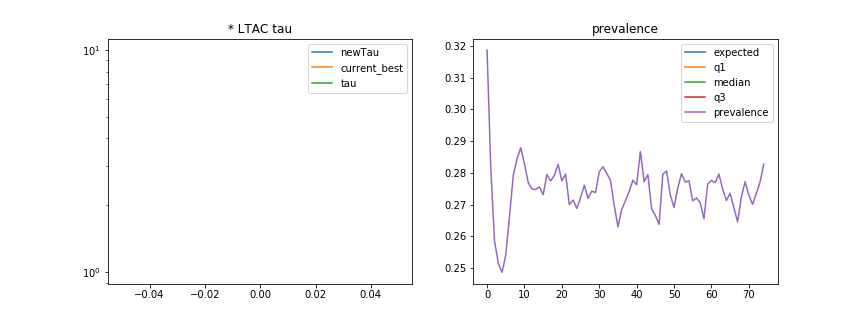

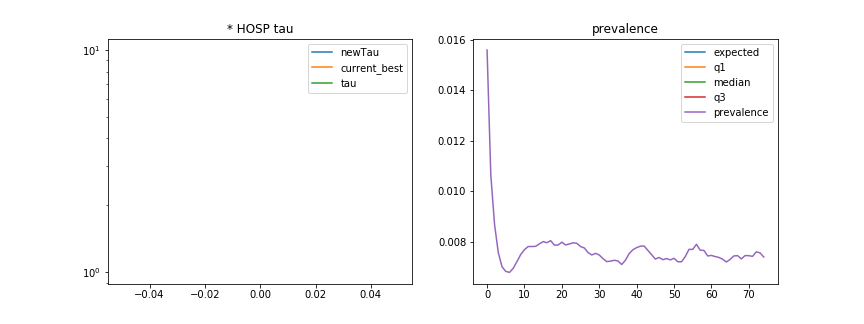

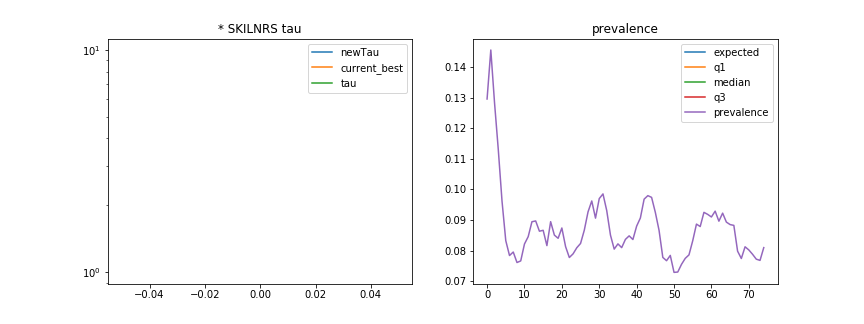

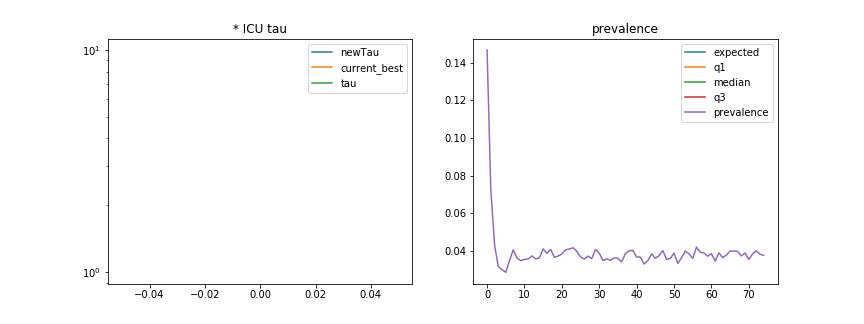

In [275]:
allTiers = set([tier for loc, tier in tierPairs])
for tier in allTiers:
    plotLoc('*', tier, fullDF)

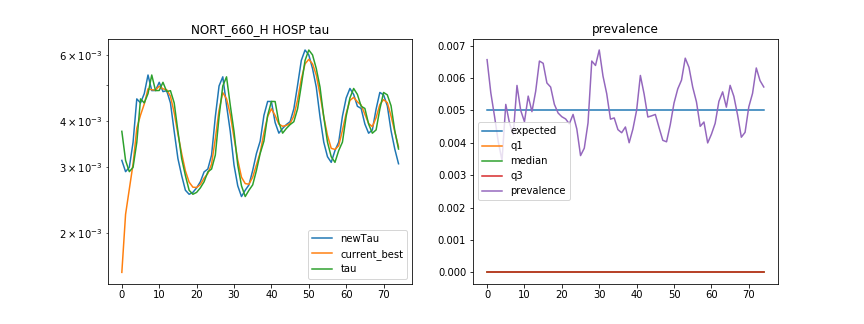

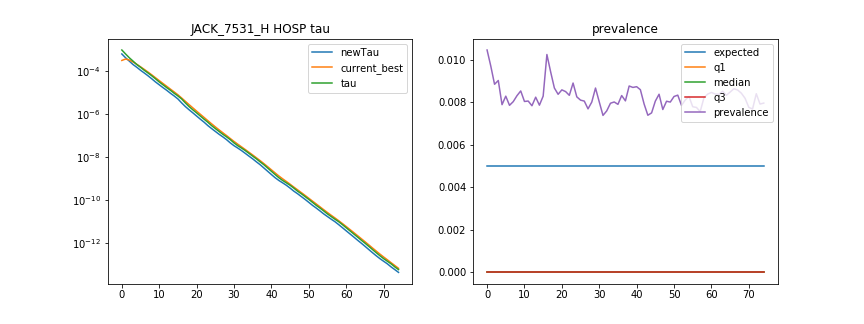

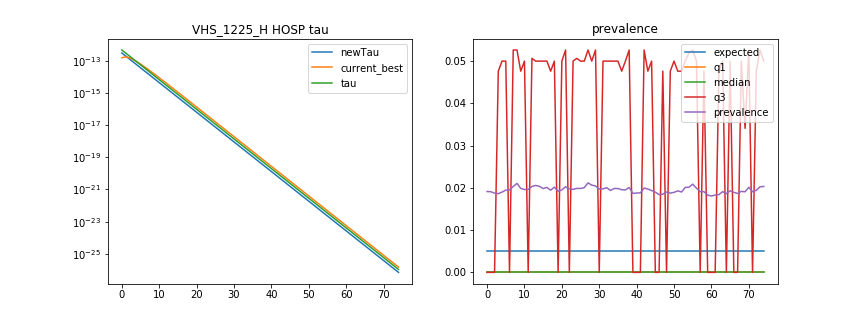

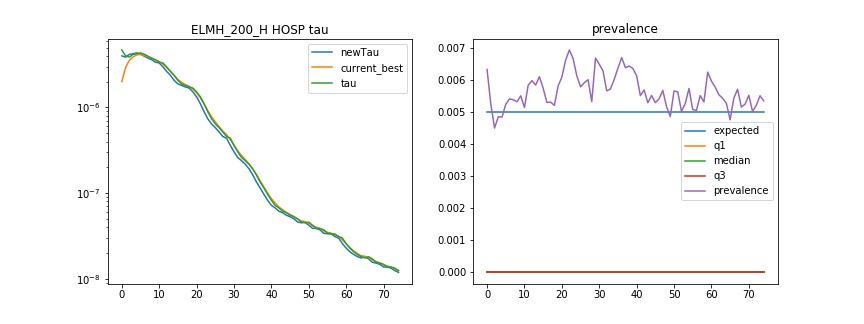

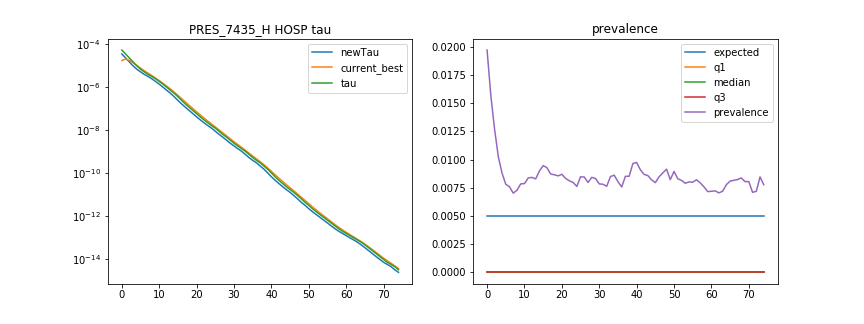

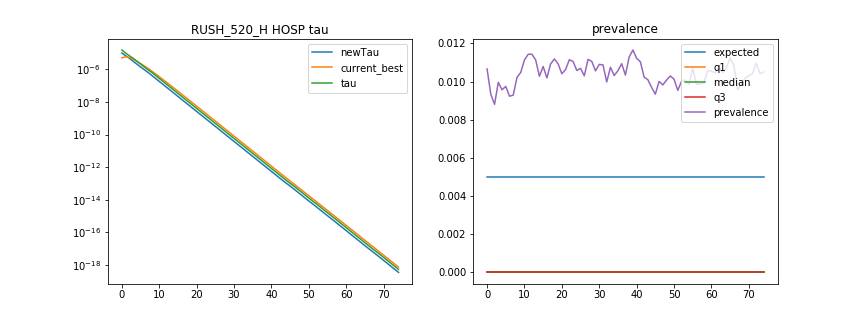

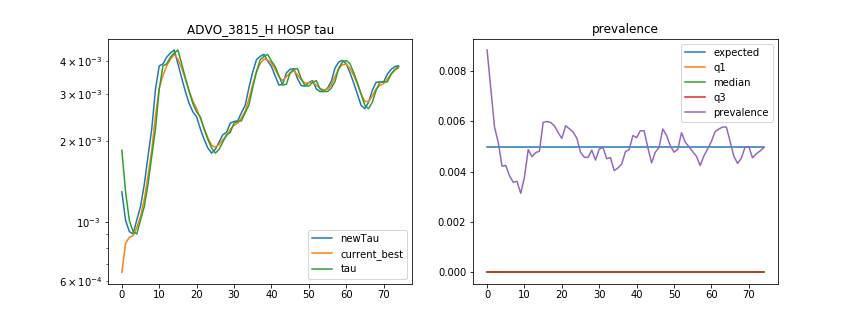

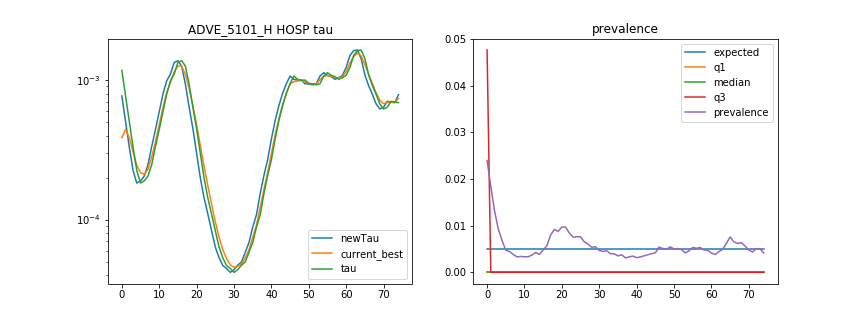

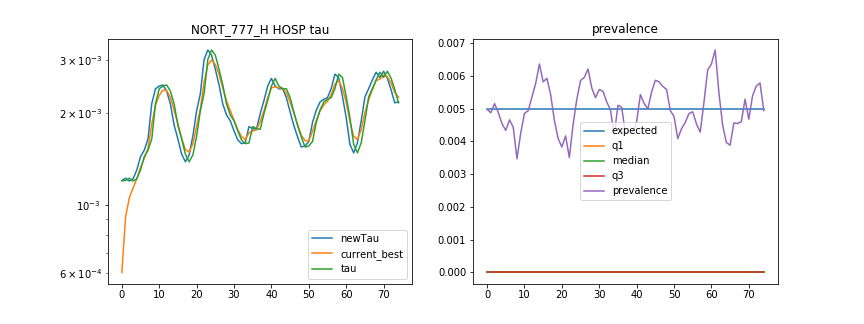

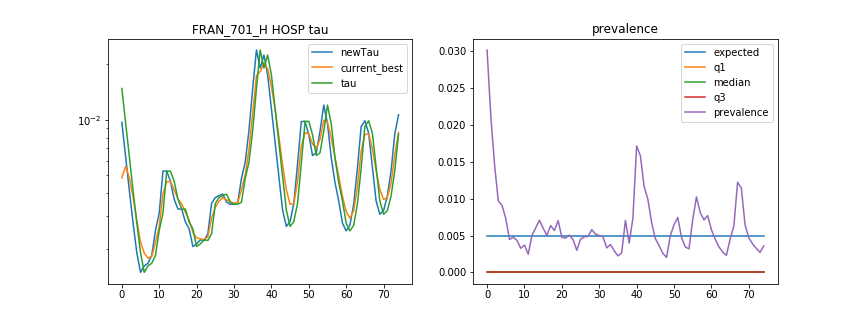

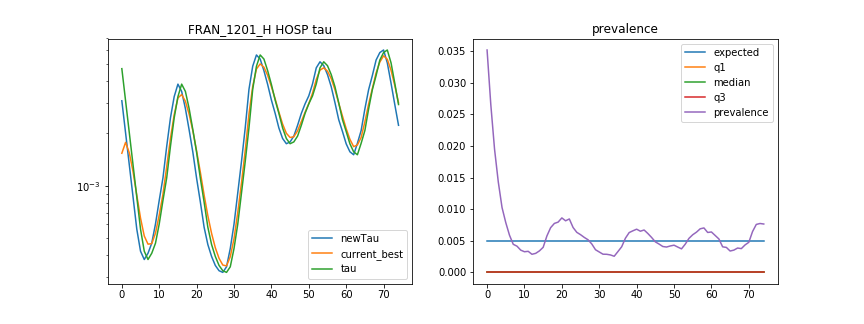

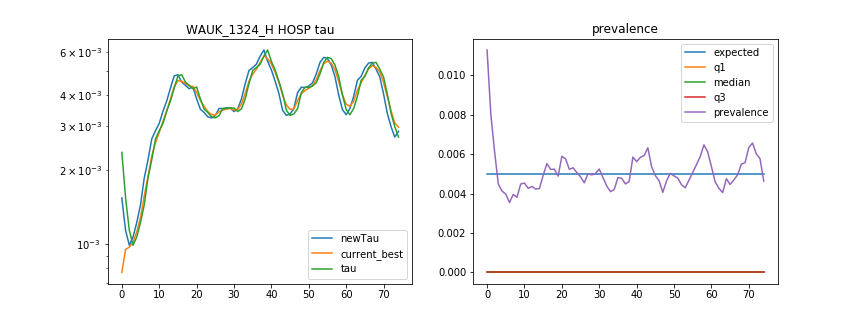

In [302]:
# Tau plots
#ctg, tier = 'SNF', 'NURSING'
ctg, tier = 'HOSPITAL', 'HOSP'
#ctg, tier = 'HOSPITAL', 'ICU'
#ctg, tier = 'LTACH', 'LTAC'
#ctg, tier = 'VSNF', 'SKILNRS'
#ctg, tier = 'VSNF', 'VENT'
#ctg, tier = 'VSNF', 'NURSING'
count = 0
candidateL = []
for loc, rec in facDict.items():
    if rec['category'] == ctg:
        candidateL.append((loc, tier))
random.seed(1234) # for consistency
random.shuffle(candidateL)
for loc, tier in candidateL[:12]:
    plotLoc(loc, tier, fullDF)


In [297]:
zeroD = defaultdict(list)
oneD = defaultdict(list)
goodD = defaultdict(list)
invalidD = defaultdict(list)
maxSamp = fullDF['samp'].max()
for cat, tier in tierPairs:
    for fac, rec in facDict.items():
        if rec['category'] == cat:
            locDF = fullDF[np.logical_and(fullDF['fac']==fac, fullDF['tier']==tier)]
            #print fac, tier, len(locDF)
            sampDF = locDF[locDF['samp']>=maxSamp-15]
            tau = sampDF.mean()['tau']
            #print fac, tier, sampDF.mean()['tau']
            if np.isnan(tau):
                invalidD[(cat, tier)].append(fac)
            elif tau > 0.8:
                oneD[(cat, tier)].append(fac)
            elif tau < 1.0e-6:
                zeroD[(cat, tier)].append(fac)
            else:
                goodD[(cat, tier)].append(fac)
print 'cat\ttier\tgood\tzero\tone\tnan'
for cat, tier in tierPairs:
    print '%s\t%s\t%s\t%s\t%s\t%s' % (cat[:6], tier, len(goodD[(cat,tier)]),
                         len(zeroD[(cat, tier)]), len(oneD[(cat, tier)]), len(invalidD[(cat,tier)]))
            


cat	tier	good	zero	one	nan
SNF	NURSING	28	323	0	0
VSNF	NURSING	1	11	0	0
HOSPIT	HOSP	57	33	0	0
HOSPIT	ICU	22	5	63	0
LTACH	LTAC	6	3	0	0
VSNF	SKILNRS	10	1	0	1
VSNF	VENT	12	0	0	0


In [291]:
zeroD = defaultdict(list)
oneD = defaultdict(list)
goodD = defaultdict(list)
invalidD = defaultdict(list)
monoUpD = defaultdict(list)
monoDnD = defaultdict(list)
maxSamp = fullDF['samp'].max()
for cat, tier in tierPairs:
    for fac, rec in facDict.items():
        if rec['category'] == cat:
            locDF = fullDF[np.logical_and(fullDF['fac']==fac, fullDF['tier']==tier)]
            #print fac, tier, len(locDF)
            sampDF = locDF[locDF['samp']>=maxSamp-15]
            sampV = sampDF['tau'].values
            gradV = sampV[1:-1] - sampV[0:-2]
            monotonicDown = all(gradV <= 0.0)
            monotonicUp = all(gradV >= 0.0)
            #print fac, tier, monotonicDown, monotonicUp
            tau = sampDF.mean()['tau']
            #print fac, tier, sampDF.mean()['tau']
            if monotonicUp:
                monoUpD[(cat, tier)].append(fac)
            if monotonicDown:
                monoDnD[(cat, tier)].append(fac)
            if np.isnan(tau):
                invalidD[(cat, tier)].append(fac)
            elif tau > 0.8:
                oneD[(cat, tier)].append(fac)
            elif tau < 1.0e-6:
                zeroD[(cat, tier)].append(fac)
            else:
                goodD[(cat, tier)].append(fac)
print 'cat\ttier\tgood\tzero\tone\tnan\tdown\tup'
for cat, tier in tierPairs:
    print '%s\t%s\t%s\t%s\t%s\t%s\t%s\t%s' % (cat[:6], tier, len(goodD[(cat,tier)]),
                         len(zeroD[(cat, tier)]), len(oneD[(cat, tier)]), len(invalidD[(cat,tier)]),
                                         len(monoDnD[(cat, tier)]), len(monoUpD[(cat, tier)]))
            


cat	tier	good	zero	one	nan	down	up
SNF	NURSING	28	323	0	0	340	2
VSNF	NURSING	1	11	0	0	9	1
HOSPIT	HOSP	57	33	0	0	31	1
HOSPIT	ICU	22	5	63	0	46	44
LTACH	LTAC	6	3	0	0	3	0
VSNF	SKILNRS	10	1	0	1	1	1
VSNF	VENT	12	0	0	0	1	0


/home/welling/myEnv/lib/python2.7/site-packages/ipykernel/__main__.py:16: RuntimeWarning: invalid value encountered in less_equal
/home/welling/myEnv/lib/python2.7/site-packages/ipykernel/__main__.py:17: RuntimeWarning: invalid value encountered in greater_equal


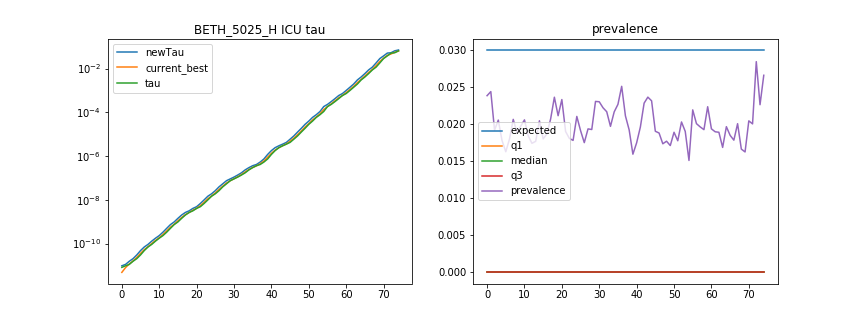

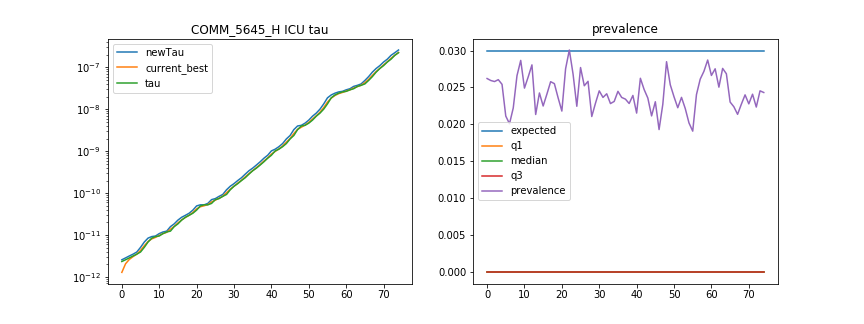

set(['BETH_5025_H', 'COMM_5645_H'])


In [292]:
cat = 'HOSPITAL'
tier = 'ICU'
diffS = set(monoUpD[(cat, tier)]) - set(oneD[(cat, tier)])
diffL = list(diffS)
diffL.sort()
for fac in diffL:
    plotLoc(fac, tier, fullDF)

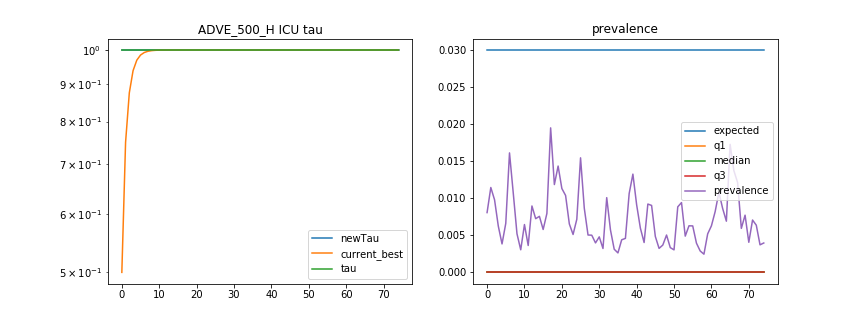

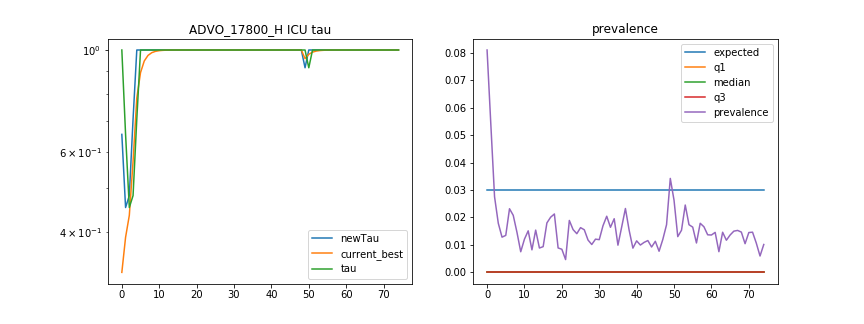

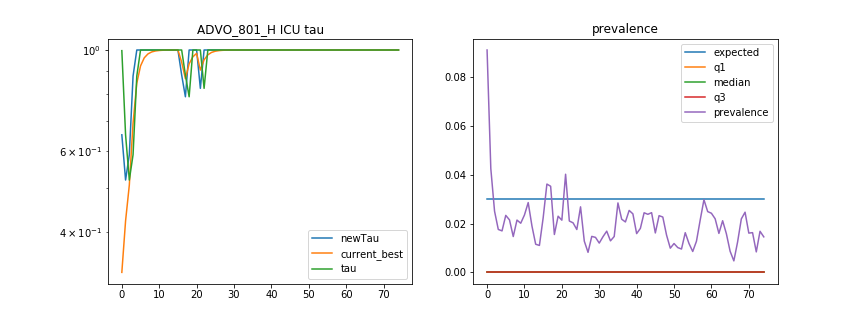

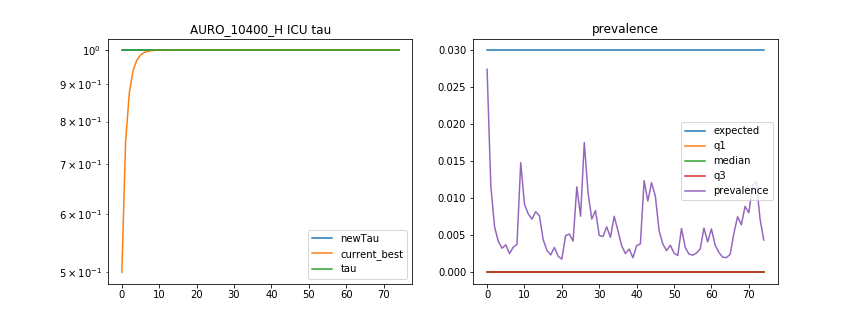

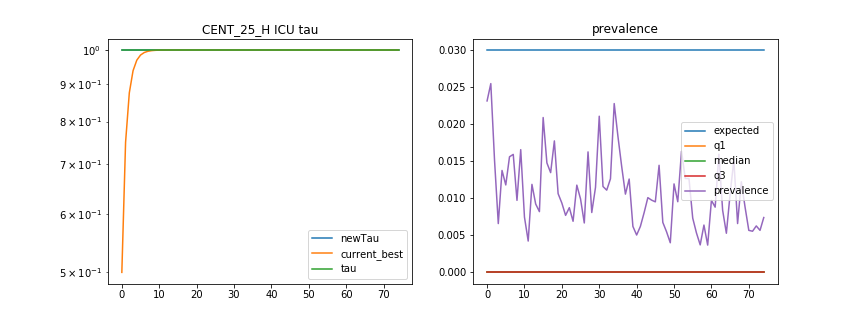

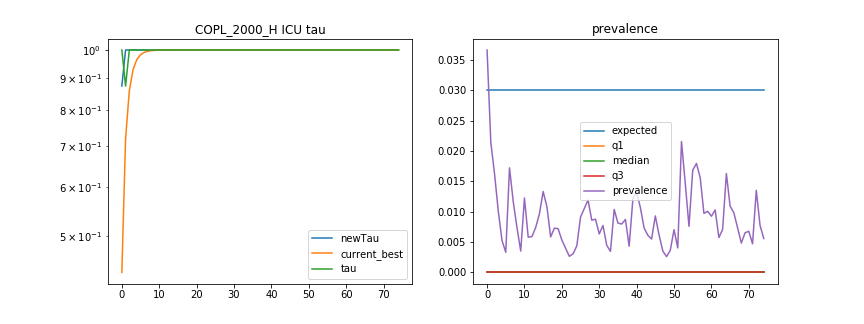

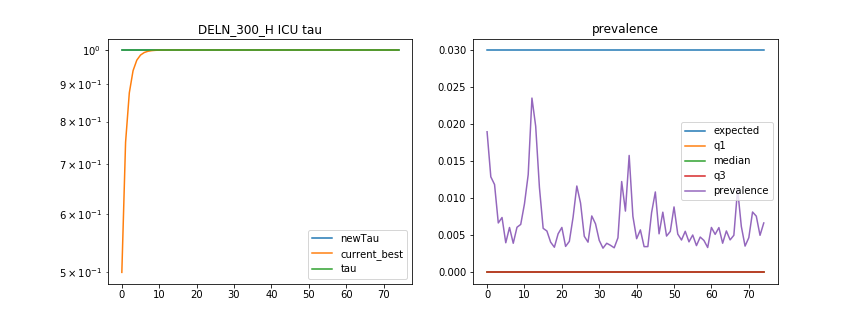

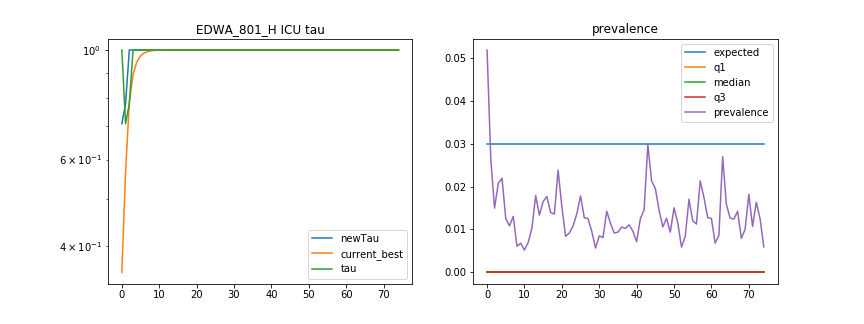

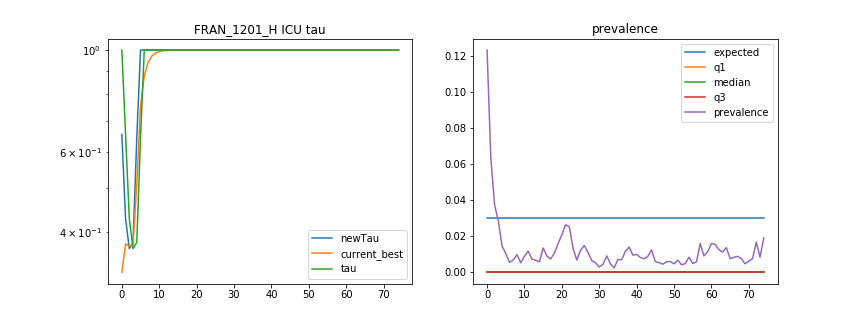

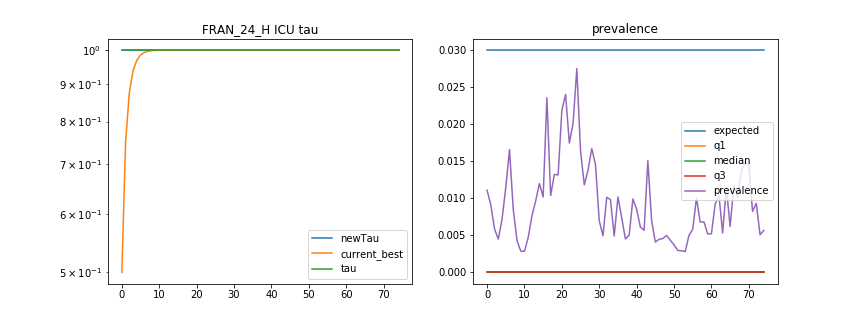

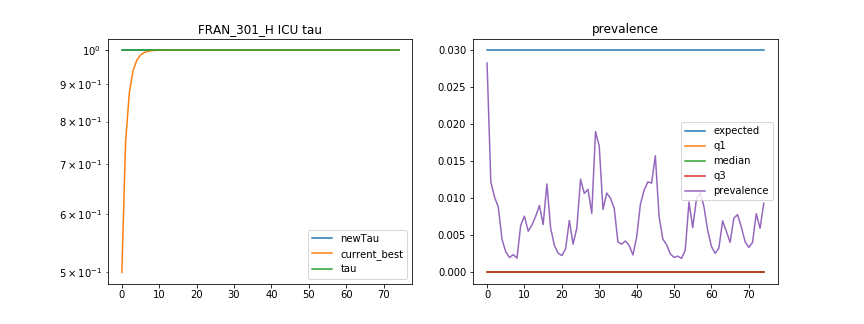

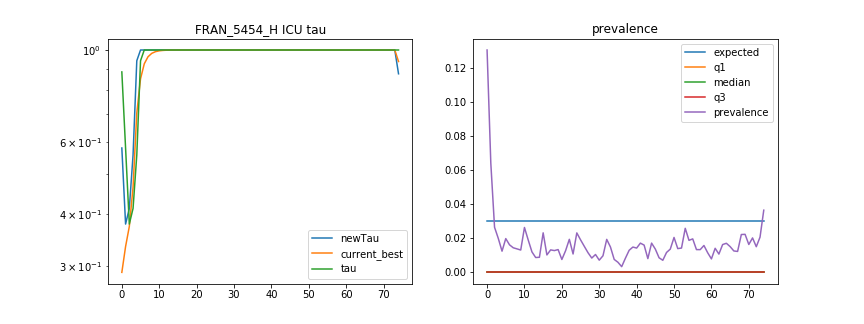

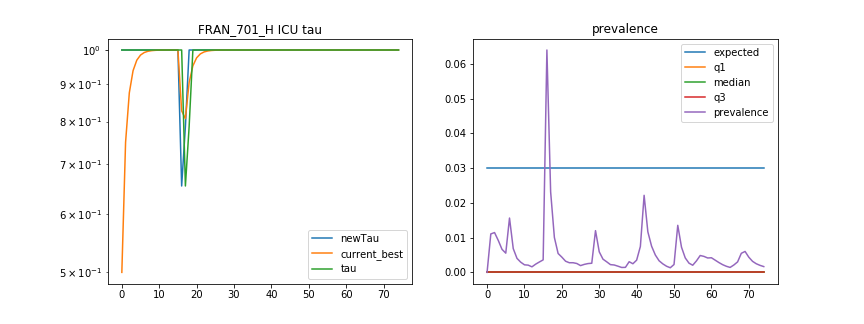

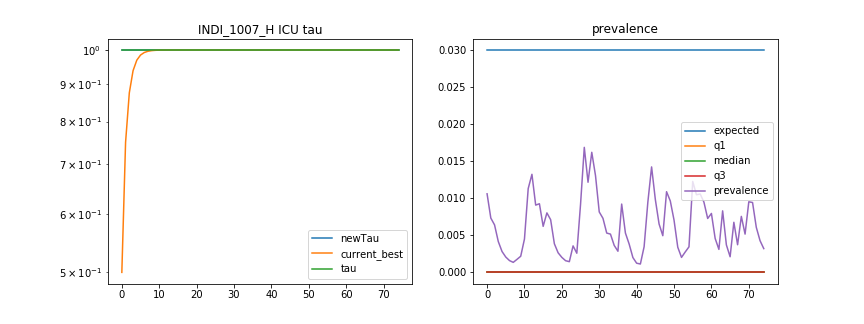

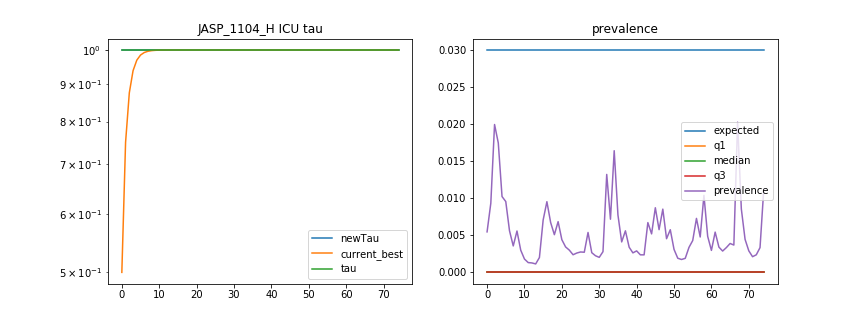

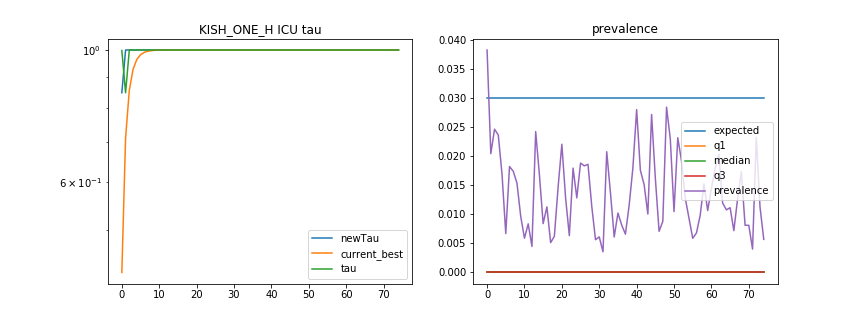

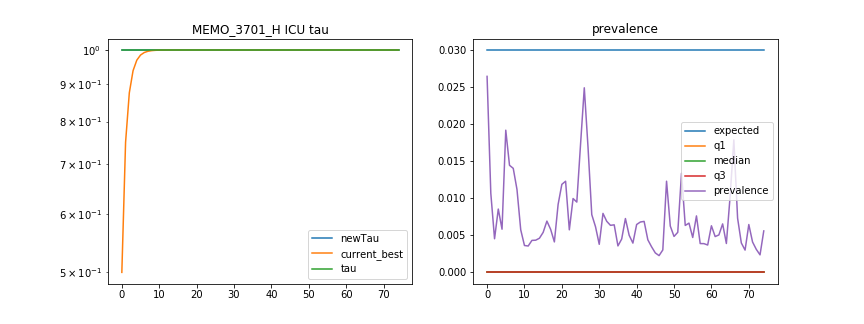

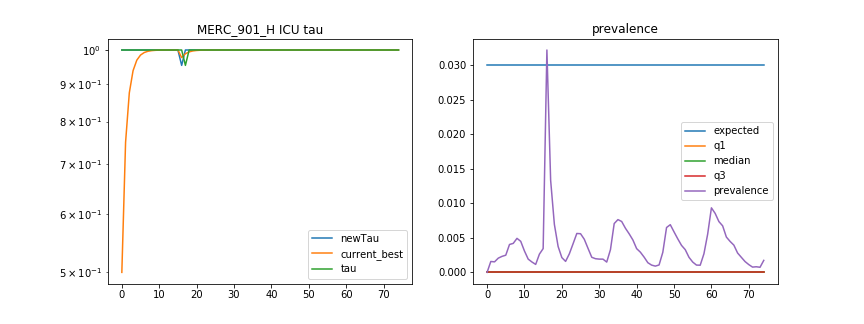

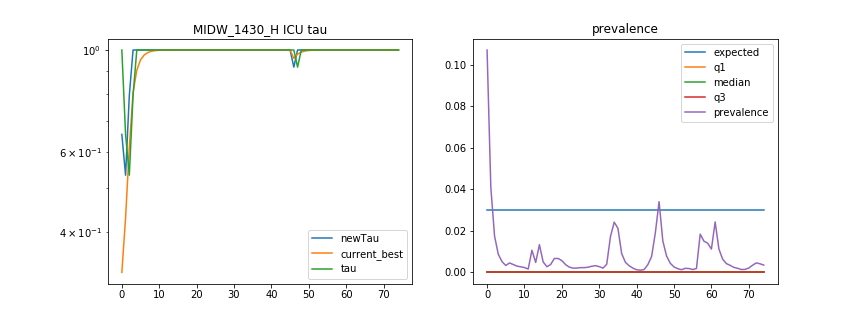

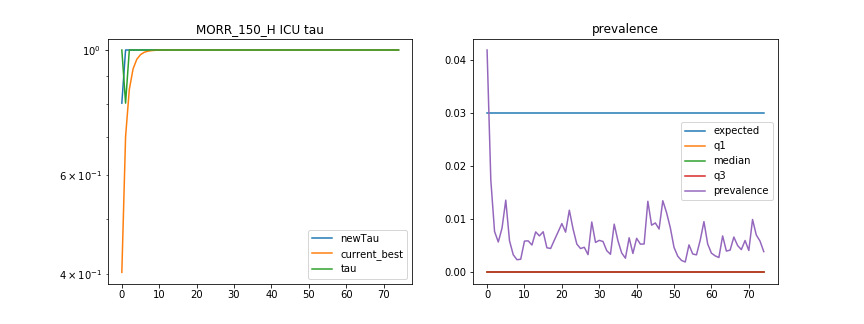

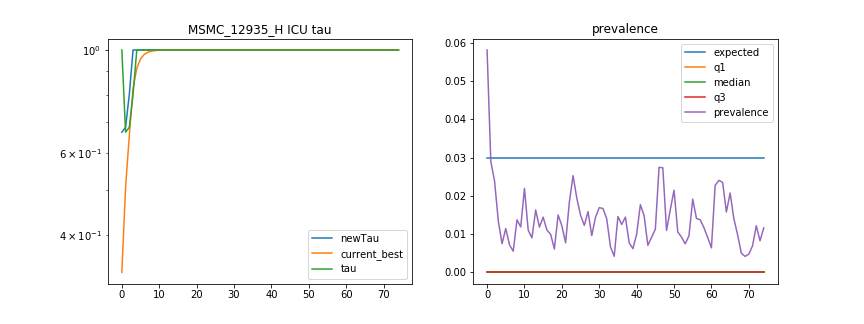

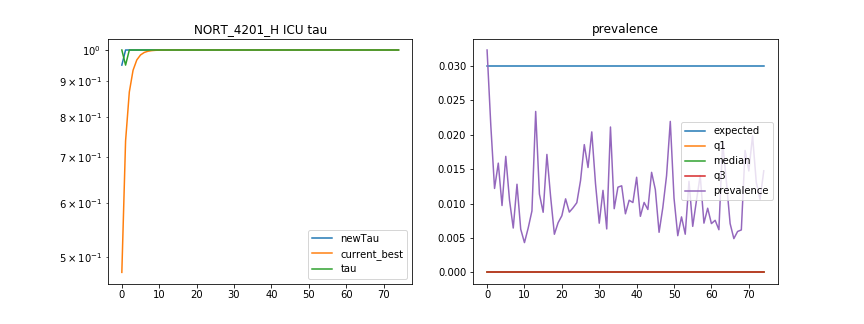

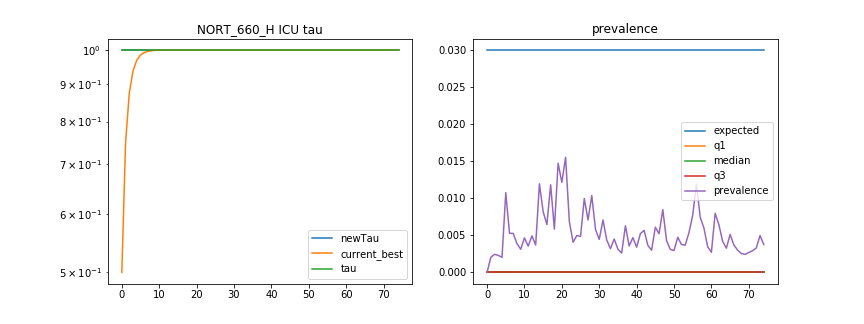

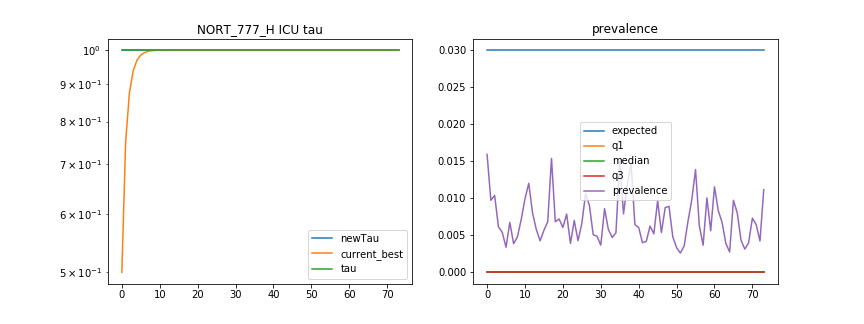

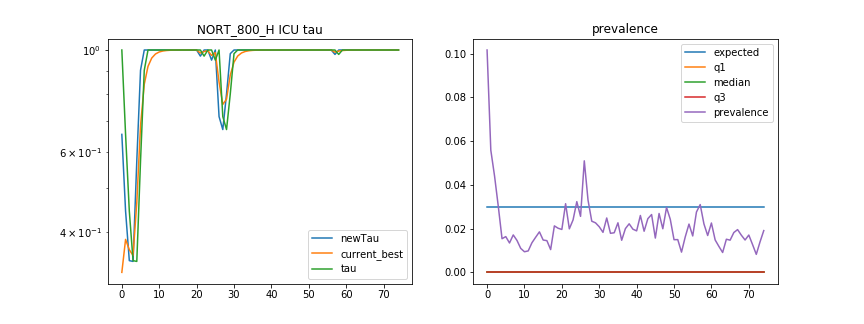

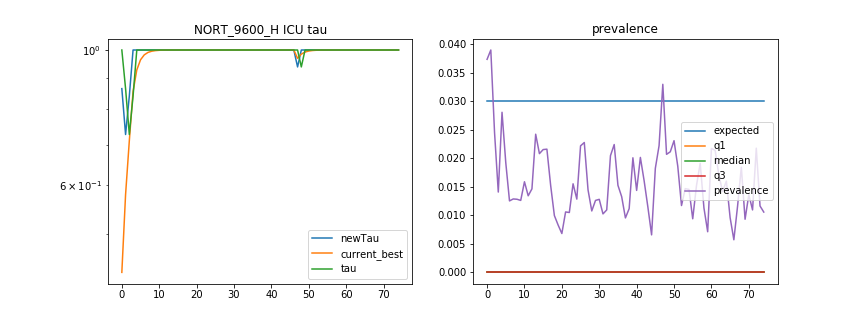

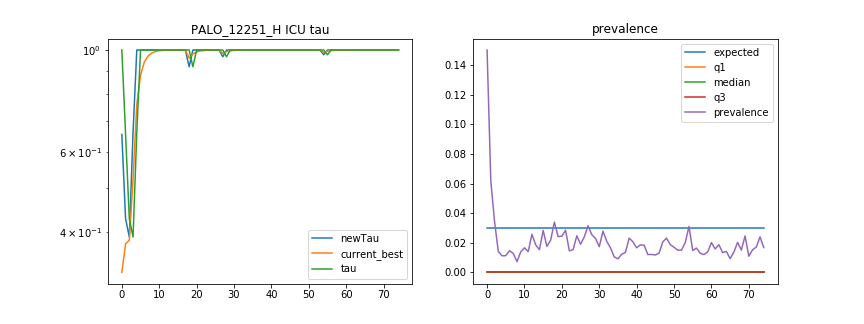

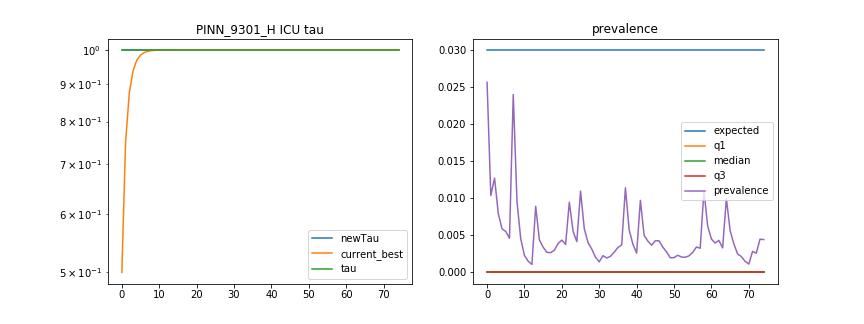

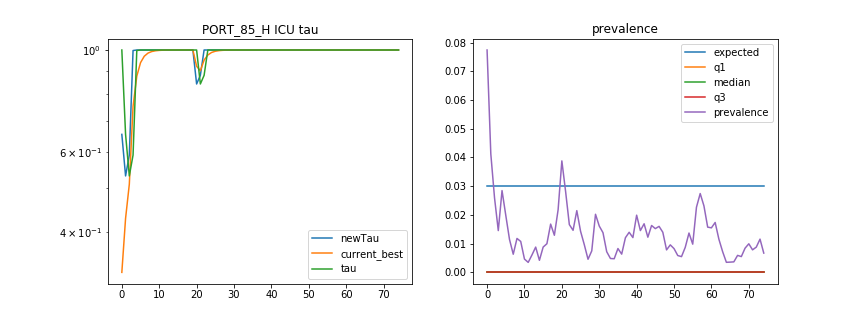

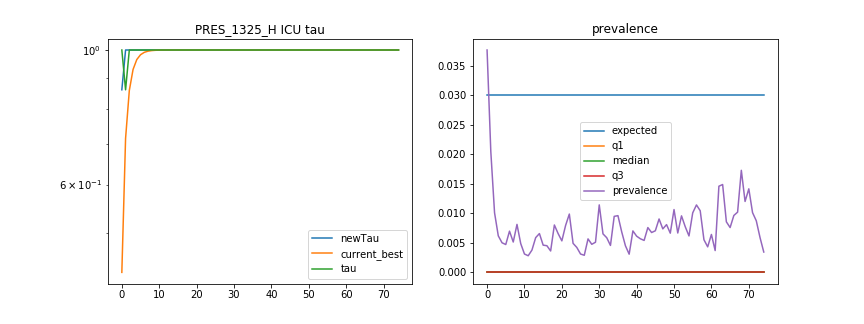

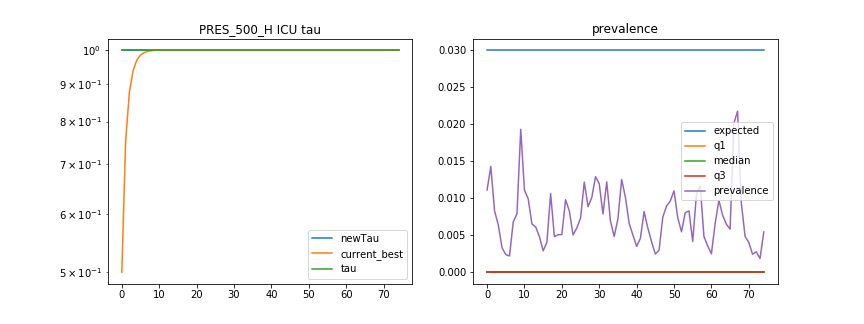

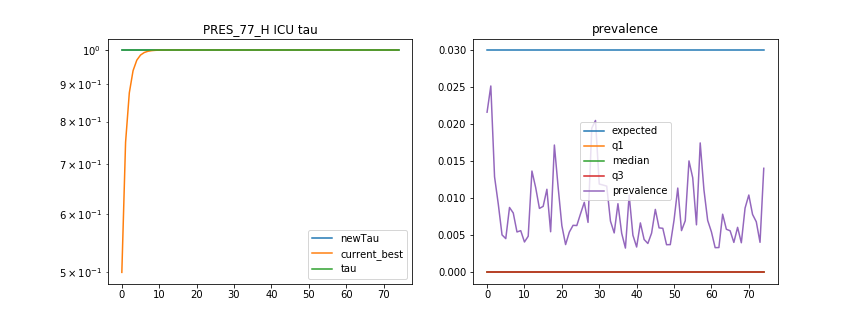

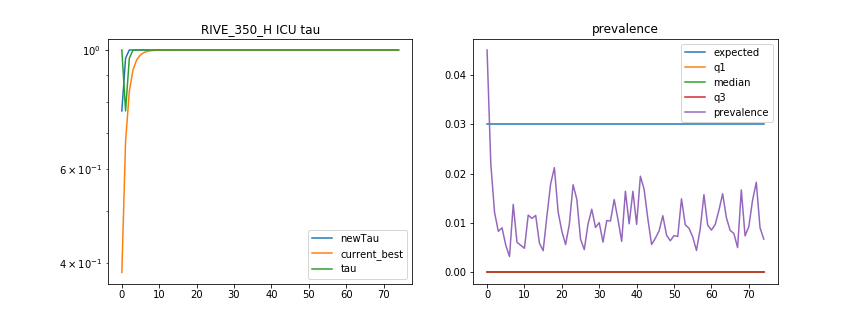

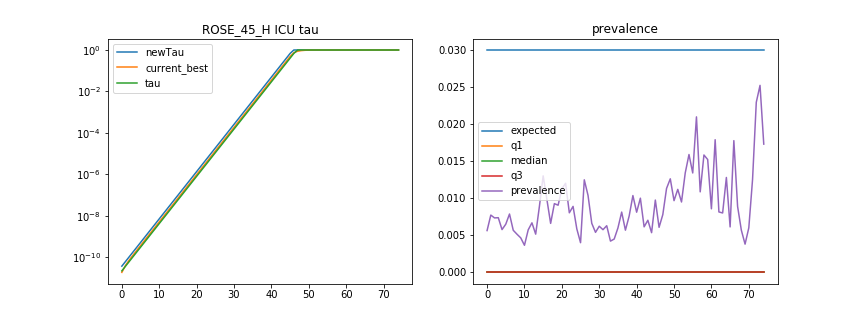

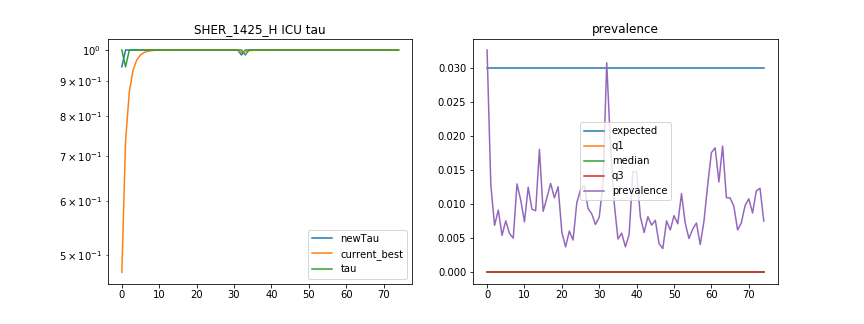

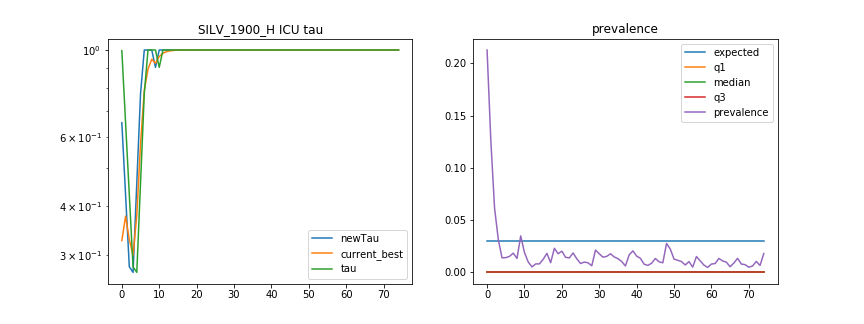

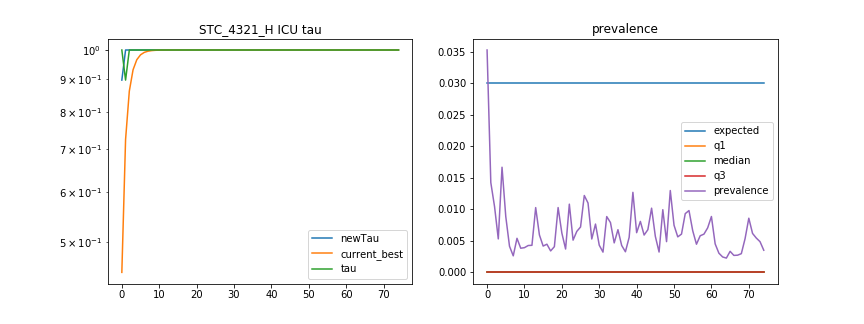

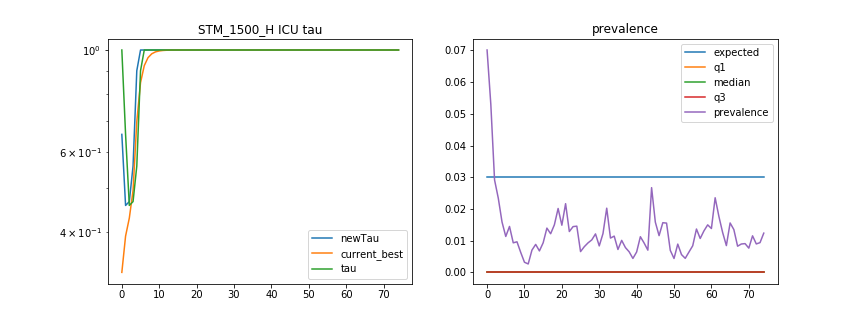

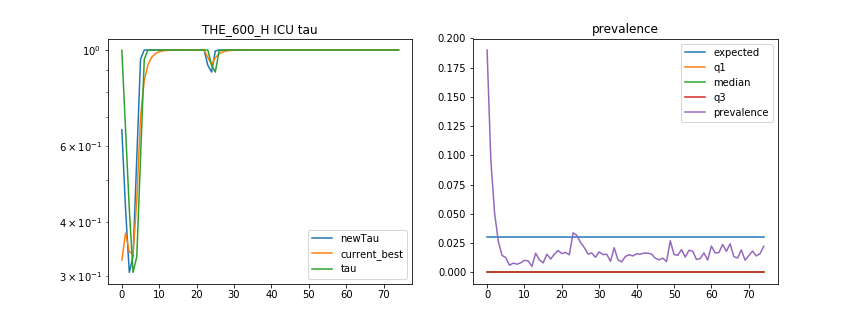

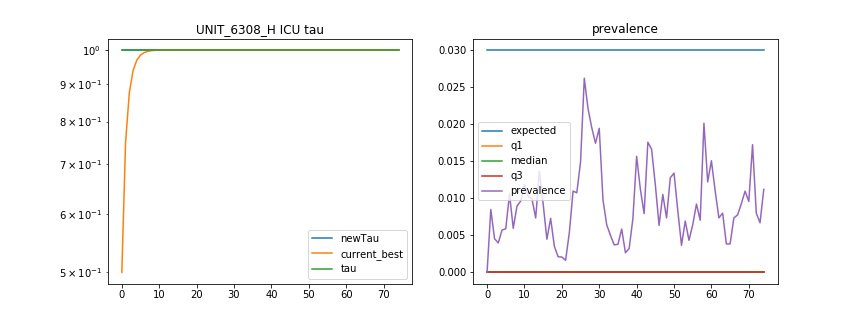

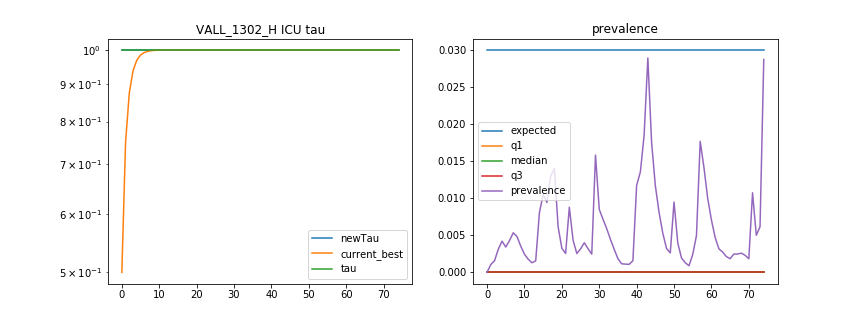

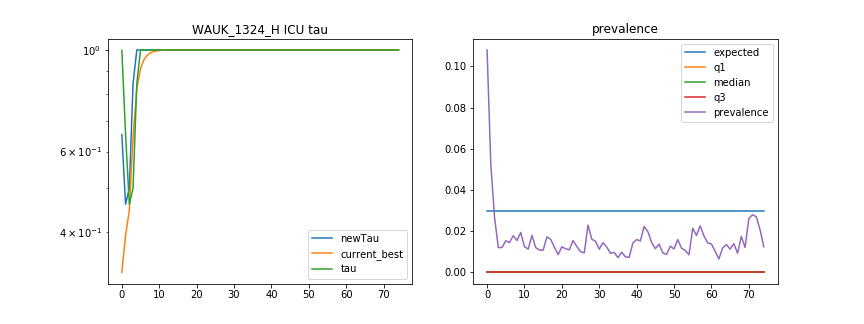

In [293]:
cat = 'HOSPITAL'
tier = 'ICU'
diffS = set(monoDnD[(cat, tier)]) - set(zeroD[(cat, tier)])
diffL = list(diffS)
diffL.sort()
for fac in diffL:
    plotLoc(fac, tier, fullDF)

In [278]:
tot = 0.0
count = 0
for fac, rec in facDict.items():
    if rec['category'] == 'VSNF':
        print fac, rec['meanLOS']['value']
        tot += rec['meanLOS']['value']
        count += 1
print 'unweighted mean LOS across all SNFs: ', tot/count

GLEN_270_S 200.560460653
GLEN_2451_V 141.903177005
GLEN_8333_V 96.14968815
PINN_2222_S 126.400295421
ALDE_820_V 149.610586011
STA_1725_V 135.935
ELMW_7733_V 174.576233184
SALE_1314_S 144.053016453
THI_5400_S 24.910933661
BALL_9300_V 83.921960073
GLEN_22660_V 147.693014706
OAK_9525_V 117.995689655
unweighted mean LOS across all SNFs:  128.642504581


## Estimating tau for an ICU ##

```
Prevalence: 0.03
mean ICU LOS: 3.67
Ward size: 12 beds max
mean exposures: 12 * 3.67 * 0.03 = 1.32
1.32 * tau = 0.03
tau = 0.023
```


## Estimating tau for a HOSP ward ##

```
Prevalence: 0.05
mean ICU LOS: 5.41
Ward size: 20 beds max
mean exposures: 20 * 5.41 * 0.05 = 5.41
5.41 * tau = 0.05
tau = 0.0092
```


## Estimating tau for a NURSING ward ##

```
Prevalence: 0.015
mean ICU LOS: 118.8
facility size: 125.4 beds mean
mean exposures: 125.4 * 118.8 * 0.015 = 223.46
223.46 * tau = 0.015
tau = 6.7e-5
```
